In [2]:
#Load the data and inspect them

In [3]:
from google.colab import files
uploaded = files.upload()

Saving TSLA.csv to TSLA.csv


In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import pandas as pd


In [5]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['TSLA.csv']))

In [6]:
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [7]:
print(f"Total no. of columns : {len(df2.columns)}")
print(f"Total no. of rows  : {len(df2)}")

Total no. of columns : 7
Total no. of rows  : 1259


In [8]:
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [10]:
all_data = df2['Adj Close'].values.astype(float)


In [11]:
print(all_data)

[ 51.830002  52.431999  53.130001 ... 277.971985 273.175995 278.855988]


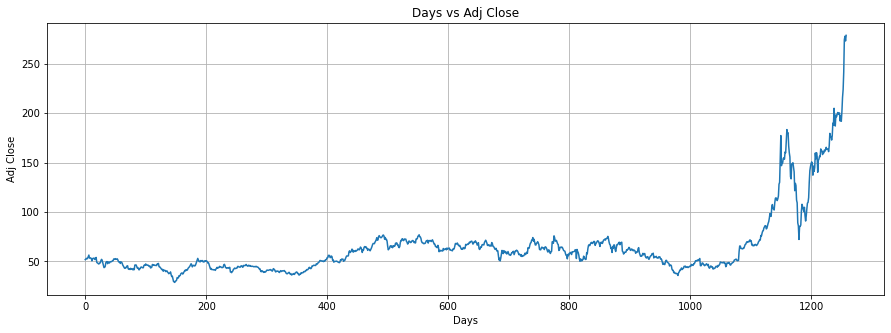

In [16]:
plt.title('Days vs Adj Close')
plt.ylabel('Adj Close')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='Date',tight=True)
plt.plot(df2['Adj Close'])

In [18]:
#Split the data into training and test sets

In [36]:
test_data_size = 14
train_data = df2[:-test_data_size]
test_data = df2[-test_data_size:]

In [20]:
print(len(train_data))
print(len(test_data))

1245
14


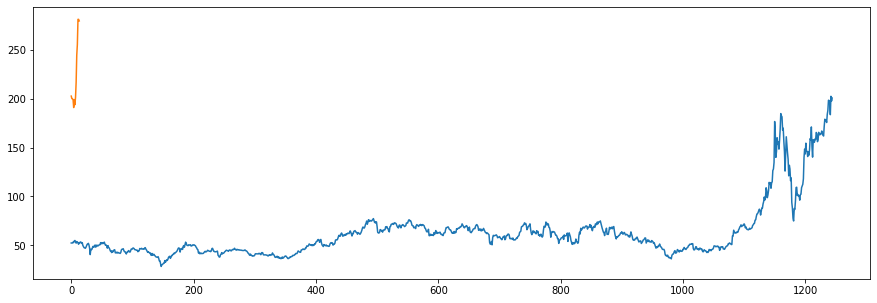

In [42]:
training_set = df2.iloc[:1245, 1:2].values
test_set = df2.iloc[1245:, 1:2].values
plt.plot(training_set, label = 'Tesla Stock Price train')
plt.plot(test_set, label = 'Tesla Stock Price test')
plt.show()

In [43]:
#Normalized the data

In [44]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = []
y_train = []
for i in range(60, 600):
    X_train.append(training_set[i-60:i, 0])
    y_train.append(training_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [46]:
#Build the input features with 1 day

In [47]:
train_window = 1

In [48]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [49]:
train_inout_seq = create_inout_sequences(X_train, train_window)

In [50]:
def sliding_windows(data, seq_length1):
    x = []
    y = []

    for i in range(len(data)-seq_length1-1):
        _x = data[i:(i+seq_length1)]
        _y = data[i+seq_length1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length1 = 1
x, y = sliding_windows(training_data, seq_length1)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [51]:
#Build LSTM mode, decide how many neurons and how many layers, and design loss function and optimizer. 

In [52]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length1
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [71]:
num_epochs = 300
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.16777
Epoch: 100, loss: 0.00297
Epoch: 200, loss: 0.00183


In [72]:
fut_pred = 14

test_inputs = X_train[-train_window:].tolist()
print(test_inputs)

[[[67.896004], [69.933998], [70.709999], [71.223999], [70.760002], [69.900002], [69.195999], [69.797997], [70.269997], [72.898003], [72.764], [72.865997], [74.902], [76.050003], [76.0], [74.599998], [74.980003], [73.297997], [70.629997], [70.185997], [69.980003], [67.975998], [68.372002], [68.503998], [67.18], [70.25], [71.199997], [70.620003], [69.93], [69.360001], [70.778], [70.589996], [71.396004], [70.751999], [70.181999], [71.194], [71.112], [70.538002], [69.975998], [67.760002], [67.339996], [65.556], [63.950001], [63.835999], [64.045998], [66.449997], [60.026001], [59.900002], [61.400002], [60.203999], [61.099998], [60.5], [60.5], [60.026001], [63.0], [61.202], [62.798], [65.134003], [62.757999], [62.172001]]]


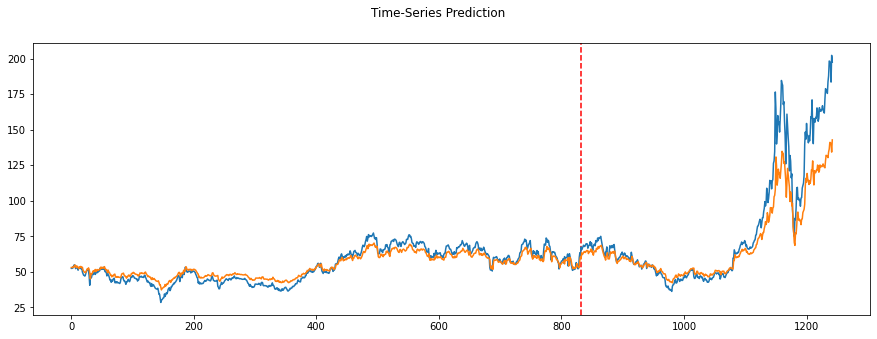

In [73]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [61]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11446
Epoch: 100, loss: 0.00401
Epoch: 200, loss: 0.00292
Epoch: 300, loss: 0.00009
Epoch: 400, loss: 0.00009
Epoch: 500, loss: 0.00009
Epoch: 600, loss: 0.00009
Epoch: 700, loss: 0.00009
Epoch: 800, loss: 0.00009
Epoch: 900, loss: 0.00009


In [62]:
fut_pred = 14

test_inputs = X_train[-train_window:].tolist()
print(test_inputs)

[[[67.896004], [69.933998], [70.709999], [71.223999], [70.760002], [69.900002], [69.195999], [69.797997], [70.269997], [72.898003], [72.764], [72.865997], [74.902], [76.050003], [76.0], [74.599998], [74.980003], [73.297997], [70.629997], [70.185997], [69.980003], [67.975998], [68.372002], [68.503998], [67.18], [70.25], [71.199997], [70.620003], [69.93], [69.360001], [70.778], [70.589996], [71.396004], [70.751999], [70.181999], [71.194], [71.112], [70.538002], [69.975998], [67.760002], [67.339996], [65.556], [63.950001], [63.835999], [64.045998], [66.449997], [60.026001], [59.900002], [61.400002], [60.203999], [61.099998], [60.5], [60.5], [60.026001], [63.0], [61.202], [62.798], [65.134003], [62.757999], [62.172001]]]


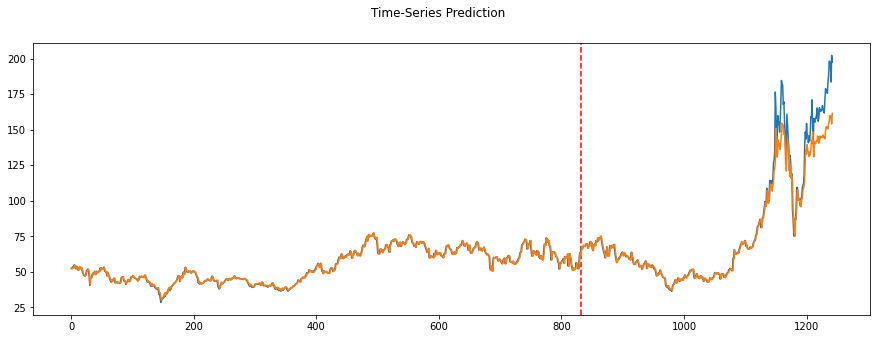

In [63]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()